Goal - look at correlation between CIL area and transport along several shelf transects

In [2]:
import glob
import os

from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import transport

import scipy.stats

In [3]:
lon_min=-70
lat_min=40
lon_max=-40
lat_max=70

In [4]:
data_dir='/ocean/handres/glorys12/'
mask = xr.open_dataset(os.path.join(data_dir,'statics_subset_mask_bathy.nc'))
mask = mask.sel(latitude=slice(lat_min, lat_max),
                longitude=slice(lon_min, lon_max))
coords = xr.open_dataset(os.path.join(data_dir,'statics_subset_coordinates.nc'))
coords = coords.sel(latitude=slice(lat_min, lat_max),
                    longitude=slice(lon_min, lon_max),
                   )

In [10]:
transects = pd.read_csv('NL-transects.csv')
                       #names=['Shortname', 'Longname', 'lon1', 'lat1', 'lon2', 'lat2', 'Dir-E', 'Dir-N'],
                       #header=0)

In [12]:
seal=transects[transects['Shortname']=='SI']

In [14]:
data_dir='/home/soontiensn/data/cmems2020-oceanstatereport/data/netcdf/GLORYSv12/monthly-means/'
f = glob.glob(os.path.join(data_dir,'*_JJA.nc'))
d = xr.open_mfdataset(f)
dsel = d.sel(
             latitude=slice(lat_min, lat_max),
             longitude=slice(lon_min, lon_max))

# Functions for cummulative transport

In [28]:
def cummulative_transport(across, transect, mask, e3t):
    lons = across.longitude.values
    lats = across.latitude.values
    dir_east_perp = transect['Dir-E'].values[0]
    dir_north_perp = transect['Dir-N'].values[0]
    transect_vector = transport.vectorize_transect(lons, lats,
                                             dir_east_perp,
                                             dir_north_perp)
    mask_transect = transport.interpolate_transect(mask, lons, lats, method='nearest')
    e3t_transect = transport.interpolate_transect(e3t, lons, lats, method='nearest')
    H = (mask_transect*e3t_transect).sum(dim='depth', skipna=True)
    H = H.where(H!=0)
    across_depth_int = transport.depth_integrate(across, mask_transect, e3t_transect)
    cumm_transport =  (across_depth_int[:,:-1]*np.abs(transect_vector)).cumsum(dim='transect')
    distance = np.abs(transect_vector).cumsum()/1e3
    return cumm_transport, distance, H

In [46]:
def plot_cumm_transport(cumm_transort, distance, H,  name):

    fig,axs = plt.subplots(2,1, figsize=(10,10))
    ax=axs[0]
    for i in range(cumm_transport.shape[0]):
        ax.plot(distance, cumm_transport.isel(time=i)/1e6)
    ax.set_ylabel('Cummulative transport [Sv]')
    ax.set_title(name)
    ax2=axs[1]
    ax2.plot(distance, H[:-1], 'k')
    ax2.set_ylim([3000,0])
    ax2.set_ylabel('depth [m]')
    ax2.grid()

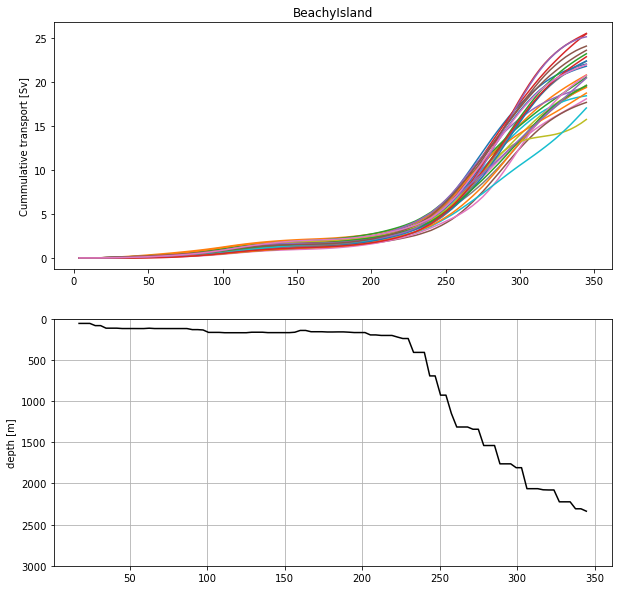

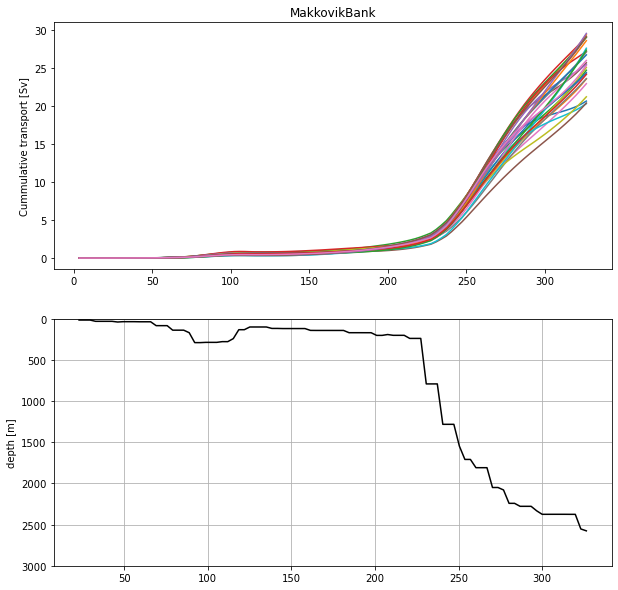

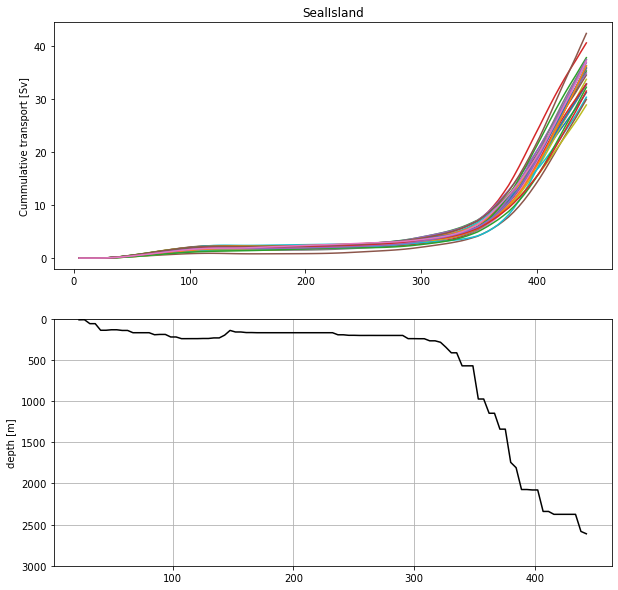

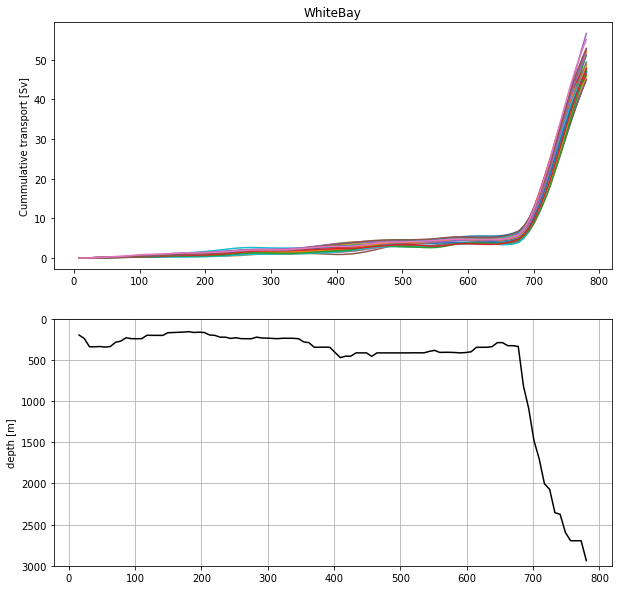

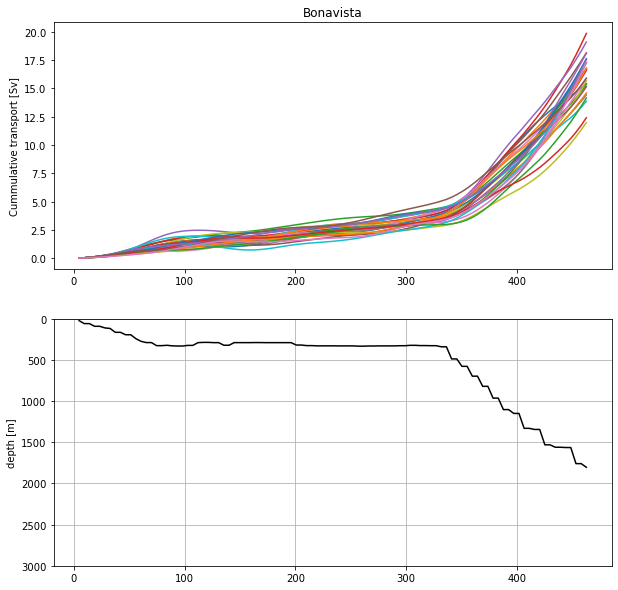

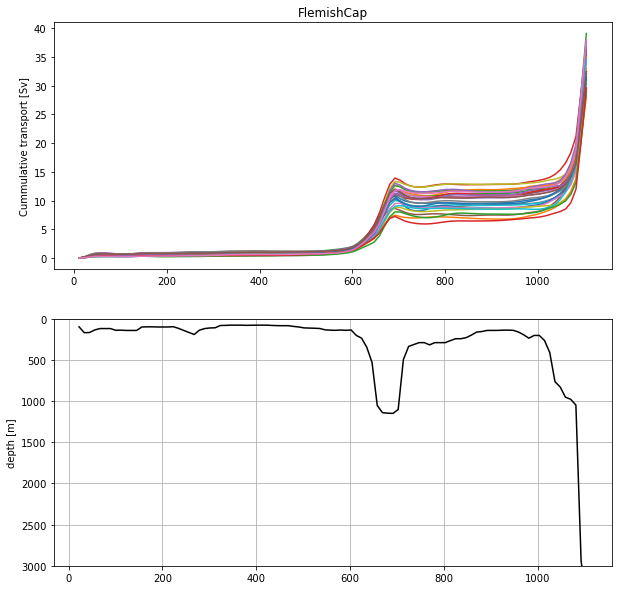

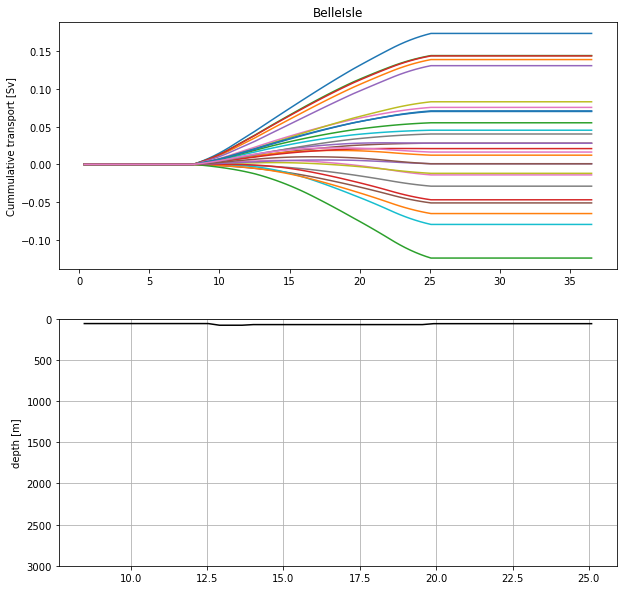

In [68]:
shelf_depth=500 # depth for defining shelf and cuting off cummulative transport
shelf_transports = {}

for name in transects.Longname.values:
    transect=transects[transects['Longname']==name]
    tfull, along, across = transport.get_transect_transport(
        dsel.uo, dsel.vo, 
        mask.mask, coords.e3t, transect, barotropic=False)
    cumm_transport, distance, H = cummulative_transport(across, transect, mask.mask, coords.e3t)
    
    plot_cumm_transport(cumm_transport, distance, H, name)
    shelf = cumm_transport.where(H[:-1]<shelf_depth)
    shelf_transports[name] = shelf.dropna(dim='transect').isel(transect=-1)

# CIL functions

In [58]:
def CIL_area(thetao, mask, e3t, transect, num_points=100):
    lons = np.linspace(transect.lon1.values[0],
                       transect.lon2.values[0],
                       num=num_points)
    lats = np.linspace(transect.lat1.values[0],
                       transect.lat2.values[0],
                       num=num_points)
    dir_east_perp = transect['Dir-E'].values[0]
    dir_north_perp = transect['Dir-N'].values[0]
    transect_vector = transport.vectorize_transect(lons, lats,
                                             dir_east_perp,
                                             dir_north_perp)
    mask_transect = transport.interpolate_transect(mask, lons, lats, method='nearest')
    e3t_transect = transport.interpolate_transect(e3t, lons, lats, method='nearest')
    H = (mask_transect*e3t_transect).sum(dim='depth', skipna=True)
    H = H.where(H!=0)
    
    temp = transport.interpolate_transect(thetao, lons,lats)
    temp_CIL_mask = xr.where(temp<0, 1,0)
    temp_CIL_depth_int = transport.depth_integrate(temp_CIL_mask,mask_transect,e3t_transect)
    CIL_area = (temp_CIL_depth_int[:,:-1]*np.abs(transect_vector)).sum(dim='transect')/1e6
    return temp, CIL_area

In [59]:
CIL_areas= {}

for name in transects.Longname.values:
    transect=transects[transects['Longname']==name]
    temp, CIL = CIL_area(dsel.thetao, mask.mask, coords.e3t, transect,)

    CIL_areas[name] = CIL

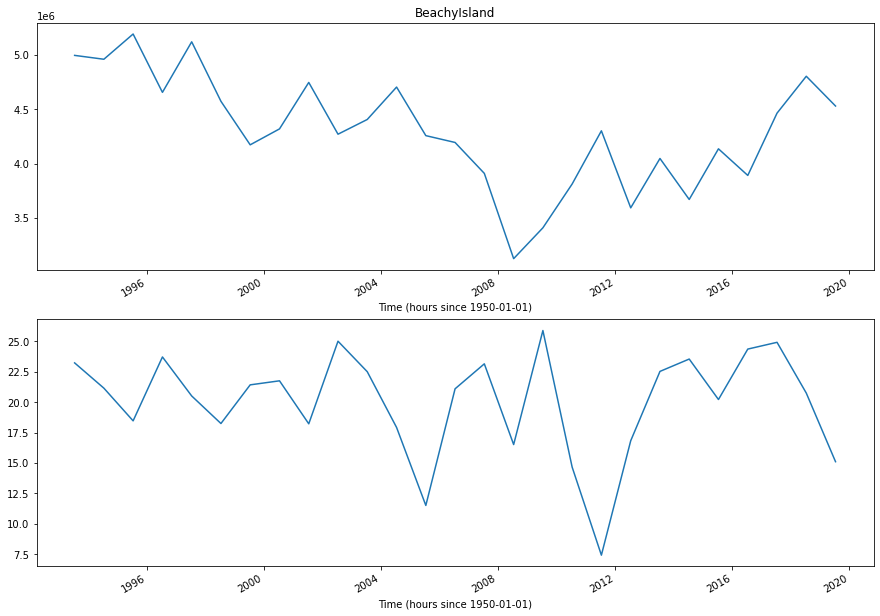

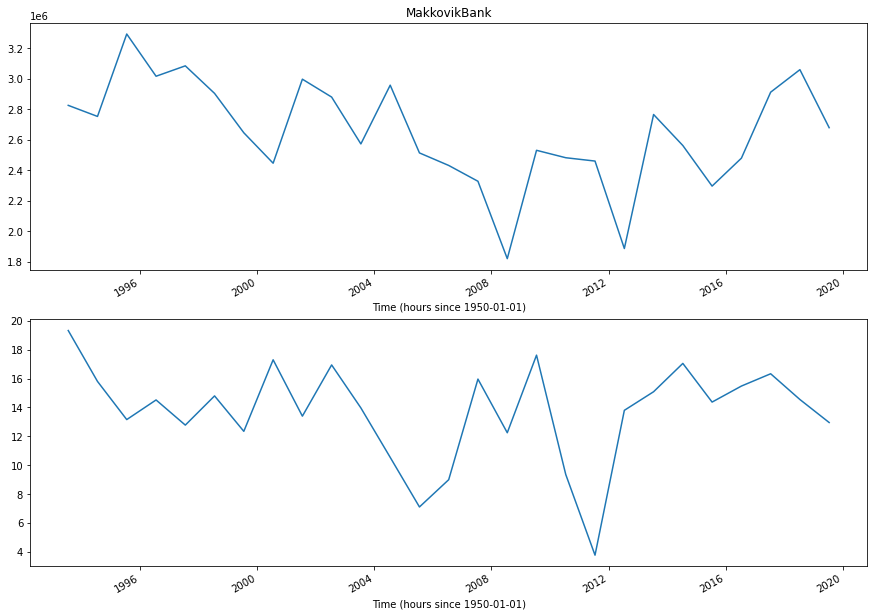

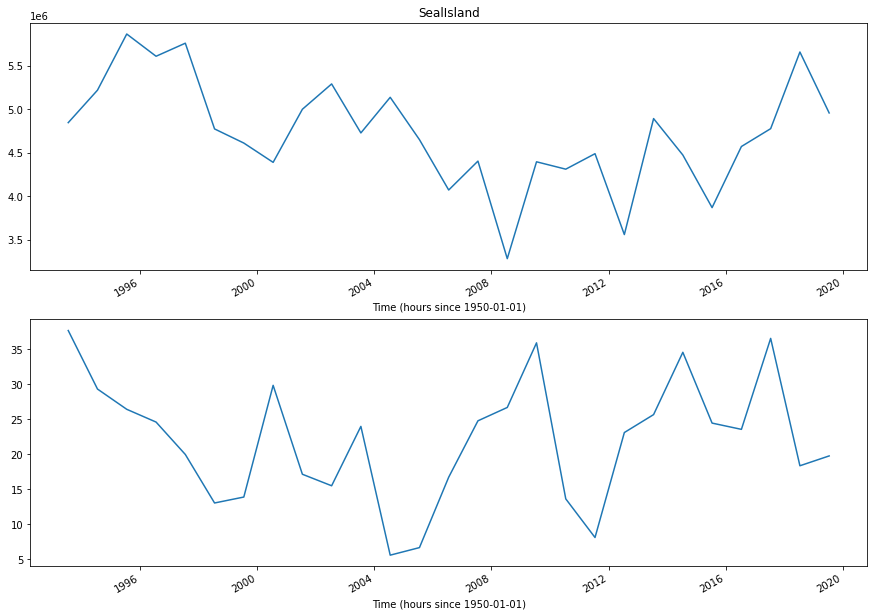

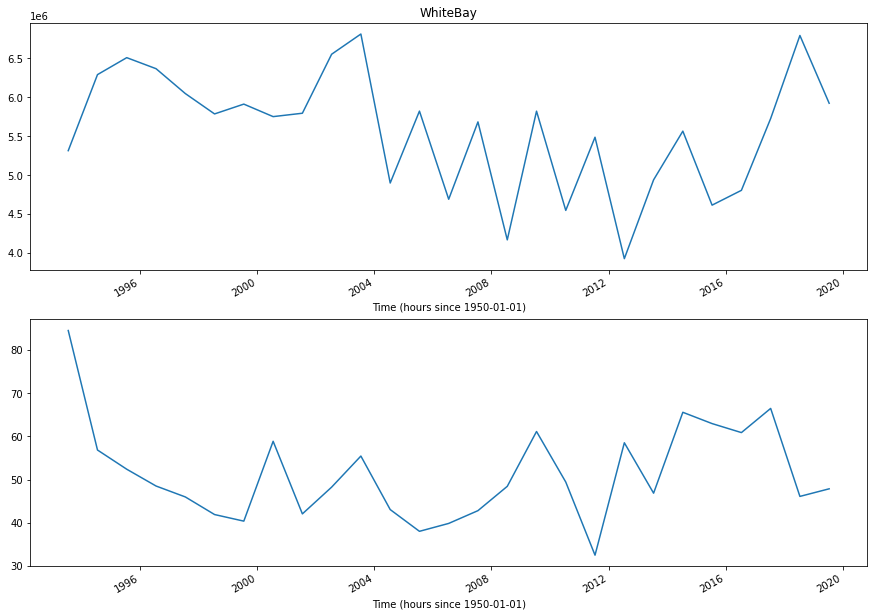

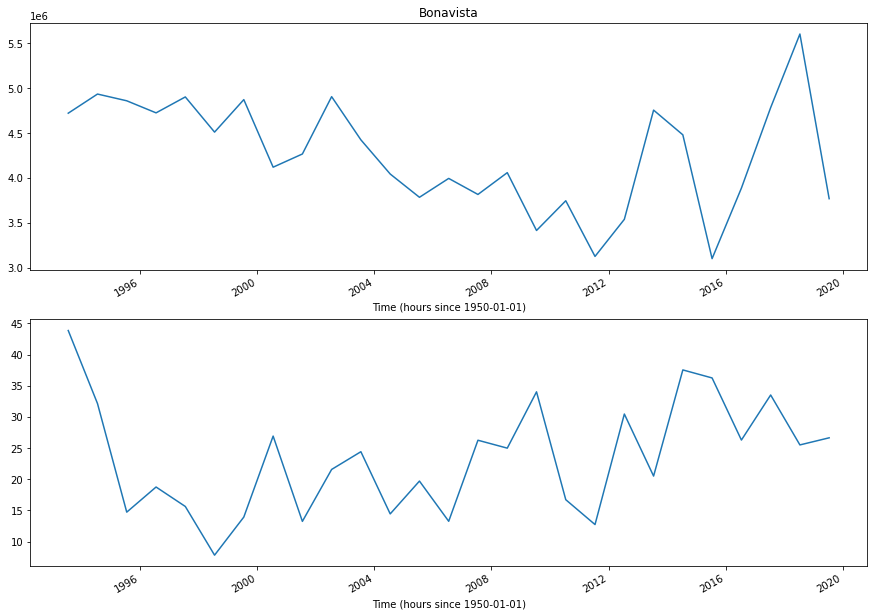

In [69]:
for name in CIL_areas:
    if name == 'FlemishCap' or name == 'BelleIsle':
        continue
    fig,axs=plt.subplots(2,1,figsize=(15,10))
    ax=axs[0]
    shelf_transports[name].plot(ax=ax)
    ax.set_title(name)
    ax=axs[1]
    CIL_areas[name].plot(ax=ax)

# Correlations and lags
Goal- Look at the correlation between transport and CIL area. Also look at lagged correlations

In [77]:
def correlation_lagged( CIL, transport, lag_year,ax):
    if lag_year >0:
        x = CIL[0:-lag_year]
        y = transport[lag_year:]
    elif lag_year ==0:
        x = CIL
        y = transport
    else:
        x = CIL[-lag_year:]
        y = transport[:lag_year]
    r, p = scipy.stats.pearsonr(x,y )
    ax.scatter(x,y)
    ax.set_xlabel('CIL Area [km^2]')
    ax.set_ylabel('Shelf transport [m^3/s]')
    ax.set_title(f'Lag year {lag_year} and r= {r:0.3f}')
    return r

Lagged scatter plot - transport +1 year

In [71]:
lag_years = [-10,-9,-8,-7,-6,-5,-4,-3,-2,-1, 0,1,2,3,4,5,6,7,8,9,10]

Text(0.5, 1.0, 'BeachyIsland')

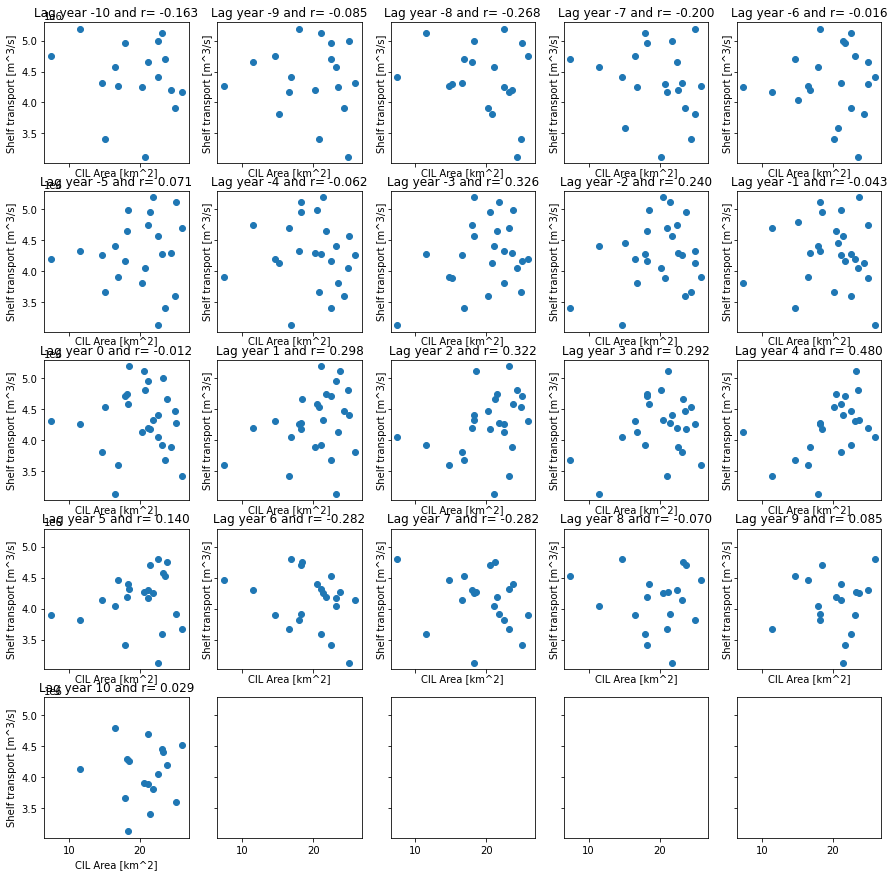

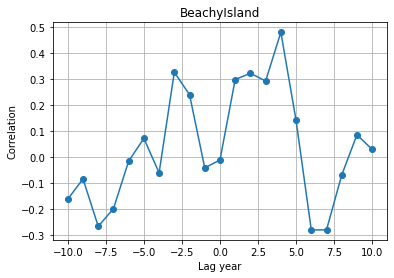

In [78]:
name='BeachyIsland'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)

rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(CIL_areas[name].values,shelf_transports[name].values, lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'MakkovikBank')

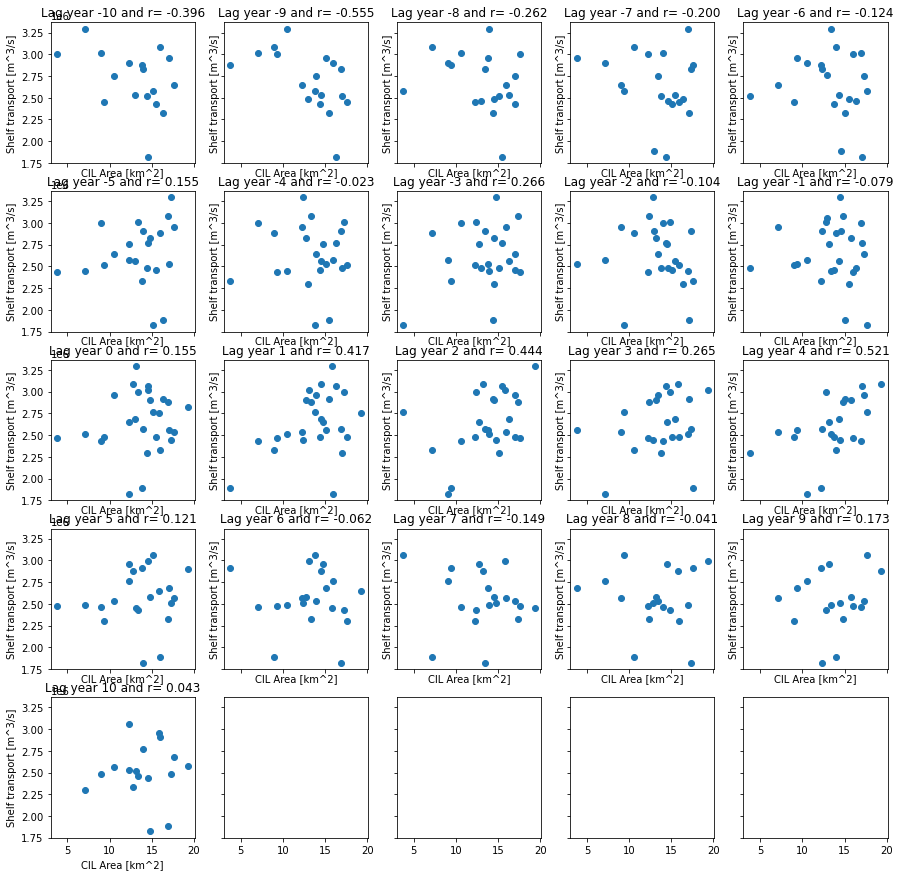

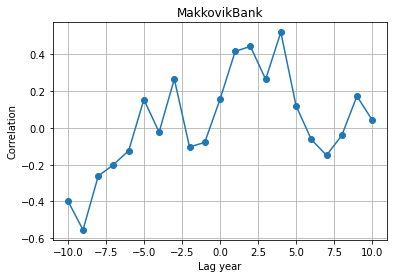

In [79]:
name='MakkovikBank'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)

rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(CIL_areas[name].values,shelf_transports[name].values, lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'SealIsland')

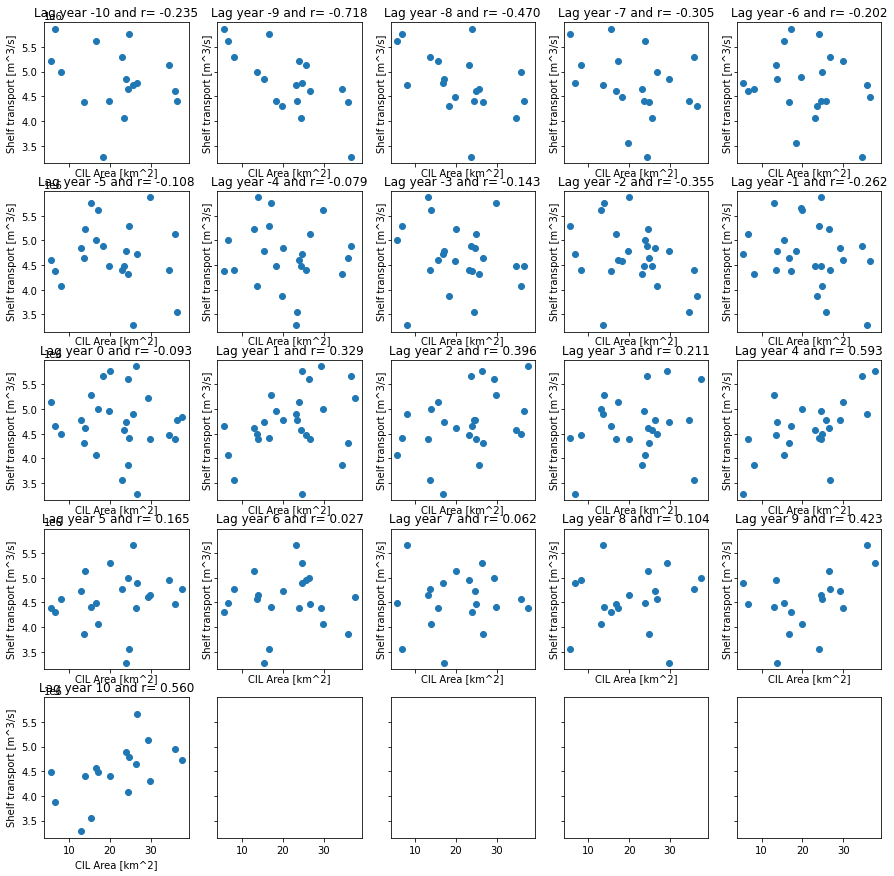

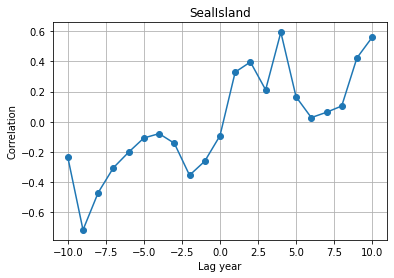

In [80]:
name='SealIsland'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)

rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(CIL_areas[name].values,shelf_transports[name].values, lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'WhiteBay')

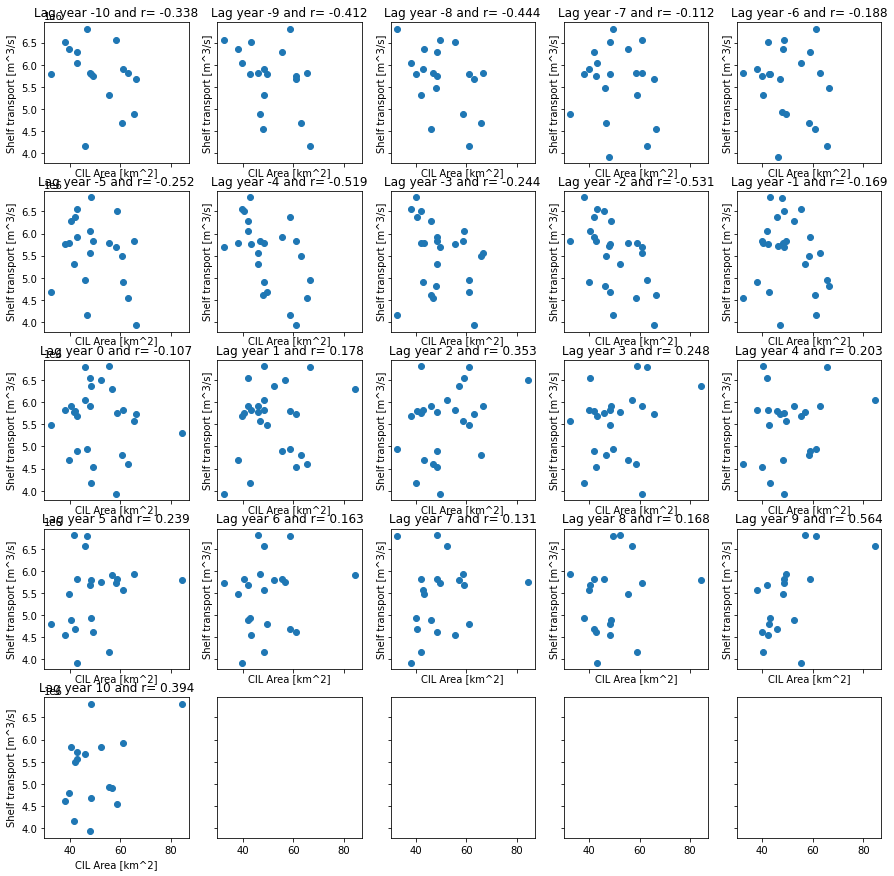

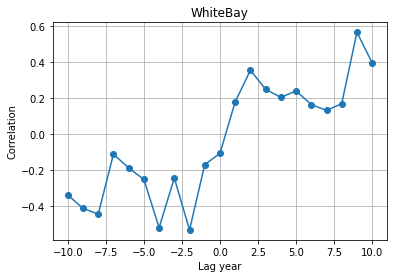

In [81]:
name='WhiteBay'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)

rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(CIL_areas[name].values,shelf_transports[name].values, lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

Text(0.5, 1.0, 'Bonavista')

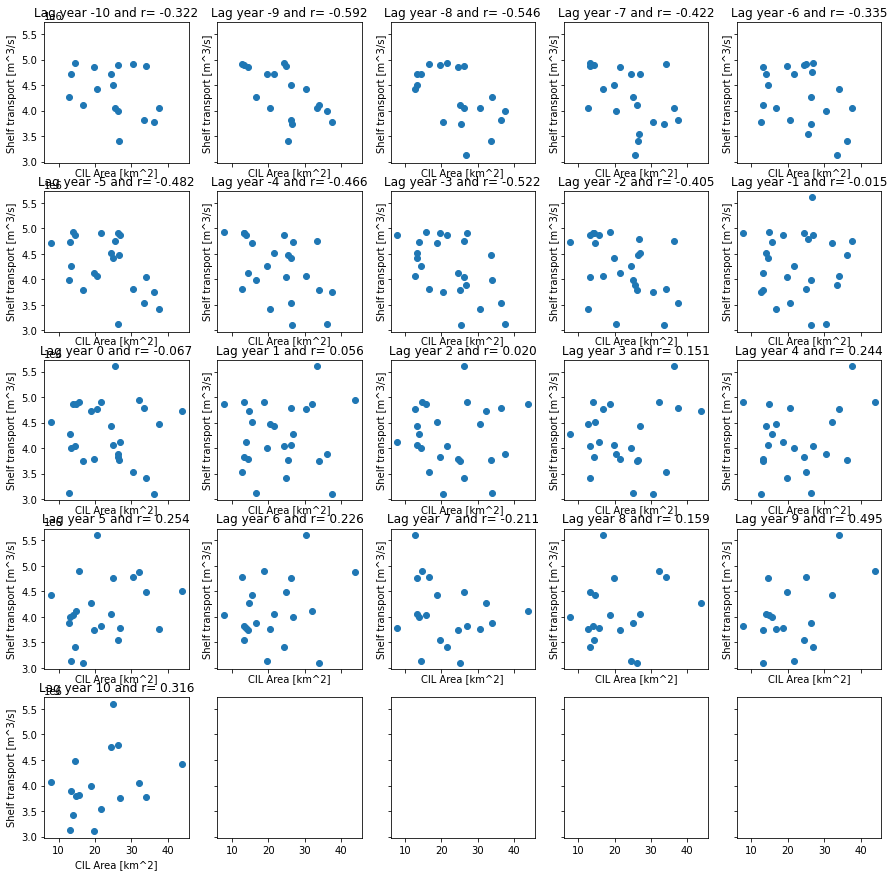

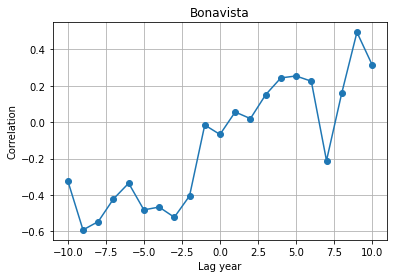

In [82]:
name='Bonavista'

fig,axs = plt.subplots(5,5,figsize=(15,15),sharex=True,sharey=True)

rs = []
for lag_year, ax in zip(lag_years, axs.flatten()):
    r = correlation_lagged(CIL_areas[name].values,shelf_transports[name].values, lag_year, ax)
    rs.append(r)
    
fig, ax = plt.subplots(1,1)
ax.plot(lag_years, rs, 'o-')
ax.set_xlabel('Lag year')
ax.set_ylabel('Correlation')
ax.grid()
ax.set_title(name)

In [88]:
# Save CIL and shelf transports into netCDF file for later computations
for name in CIL_areas:
    if name == 'FlemishCap' or name == 'BelleIsle':
        continue
    d = xr.Dataset()
    CIL=CIL_areas[name]
    CIL.attrs={'units': 'km^2'}
    shelf=shelf_transports[name]
    shelf.attrs={'units': 'm^3/s'}
    d['CIL_Area'] = CIL
    d['Shelf_Transport'] =shelf
    print(d)
    d.to_netcdf(f'{name}.nc')
                                                    

<xarray.Dataset>
Dimensions:          (time: 27)
Coordinates:
  * time             (time) datetime64[ns] 1993-07-16T12:00:00 ... 2019-07-16...
    longitude        float64 -59.46
    latitude         float64 57.67
Data variables:
    CIL_Area         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Shelf_Transport  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
<xarray.Dataset>
Dimensions:          (time: 27)
Coordinates:
  * time             (time) datetime64[ns] 1993-07-16T12:00:00 ... 2019-07-16...
    longitude        float64 -57.23
    latitude         float64 55.79
Data variables:
    CIL_Area         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Shelf_Transport  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
<xarray.Dataset>
Dimensions:          (time: 27)
Coordinates:
  * time             (time) datetime64[ns] 1993-07-16T12:00:00 ... 2019-07-16...
    longitude        float64 -52.99
    latitude         float64 54.08
Data v

In [91]:
d.CIL_Area

<xarray.DataArray 'CIL_Area' (time: 27)>
dask.array<truediv, shape=(27,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-07-16T12:00:00 ... 2019-07-16T12:00:00
    longitude  float64 -50.07
    latitude   float64 49.64
Attributes:
    units:    km^2